In [1]:
import dgl
import torch
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('E:/Dataset/project_dataset/school_graph/nodes.csv')

df_att = df.iloc[:,9:]
print(df_att.head(1))

features = torch.tensor(df_att.to_numpy())[:, 1:].float()
features.shape

        hue  saturation  lightness      edge  threshold       road  sidewalk  \
0  0.506967    0.349987   0.494954  0.148913   0.338246  18.697357  5.318451   

   building    wall     fence  ...  traffic_si  vegetation   terrain  \
0  5.036163  0.0001  4.246521  ...    0.106049   25.297546  1.777649   

         sky    person   rider       car   truck       bus  bicycle  
0  33.747101  0.015259  0.0001  2.057648  0.0001  0.209045   0.0001  

[1 rows x 22 columns]


torch.Size([1288, 21])

In [3]:
G = dgl.DGLGraph()
G

d:\anaconda3\envs\pytorch\lib\site-packages\dgl\heterograph.py:92: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning(


Graph(num_nodes=0, num_edges=0,
      ndata_schemes={}
      edata_schemes={})

In [4]:
# 添加节点并设置节点特征
num_nodes = len(df_att)
G.add_nodes(num_nodes)
G.ndata['features'] = features
G

Graph(num_nodes=1288, num_edges=0,
      ndata_schemes={'features': Scheme(shape=(21,), dtype=torch.float32)}
      edata_schemes={})

In [5]:
edge_data = pd.read_csv('E:/Dataset/project_dataset/school_graph/edges.csv')

src = edge_data['src'].tolist()
dst = edge_data['dst'].tolist()

## 注意图的序号是从0开始的
G.add_edges(src, dst)
G

Graph(num_nodes=1288, num_edges=6345,
      ndata_schemes={'features': Scheme(shape=(21,), dtype=torch.float32)}
      edata_schemes={})

In [46]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import numpy as np

label_data = pd.read_csv('E:/Dataset/project_dataset/school_graph/label.csv')
# df = pd.read_csv('E:/Dataset/GNN_Perception/Graph/road2/label_5.csv')

# 把non值去掉
label_data.dropna(subset=['label'], inplace=True)

# 平衡数据，把数量过多的标签删除
label_1 = label_data[label_data['label'] == 2]
num_rows_to_remove = int(len(label_1) * 0.3)
rows_to_remove = np.random.choice(label_1.index, num_rows_to_remove, replace=False)
label_data = label_data.drop(rows_to_remove)

# 将节点 ID 设置为 '_ID' 特征属性
G.ndata['_ID'] = torch.arange(num_nodes)
# 创建 'label' 特征属性，并将所有节点的标签初始化为0
G.ndata['label'] = torch.zeros(num_nodes, dtype=torch.long)

# 遍历每个节点 ID 并将其对应的标签赋值到图 G 上的节点
for node_id in label_data.index:
    if node_id in G.ndata['_ID']:
        label = label_data.loc[node_id, 'label']
        G.ndata['label'][G.ndata['_ID'] == node_id] = label

# 上采样数据以平衡类别
ros = RandomOverSampler(random_state=1234)
X = label_data.drop(['label'], axis=1)
y = label_data['label']
X_resampled, y_resampled = ros.fit_resample(X, y)

# 将上采样后的数据转换为DataFrame格式
df_resampled = pd.DataFrame(
    data=np.column_stack((X_resampled, y_resampled)),
    columns=[*X.columns, 'label']
)

# 划分训练集和测试集（比例0.2）
train_node_ids, test_node_ids = train_test_split(label_data.index, 
                                                 test_size=0.2, 
                                                 stratify=label_data['label'])

# 创建 'train_mask' 和 'test_mask' 特征属性，并将它们初始化为 False
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
train_mask[train_node_ids] = True
test_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask[test_node_ids] = True

G.ndata['train_mask'] = train_mask
G.ndata['test_mask'] = test_mask


g = G
labels = G.ndata['label']
features = G.ndata['features']
train_mask = G.ndata['train_mask']
test_mask = G.ndata['test_mask']

# 使用 PyTorch 的 unique() 方法获取所有不同的标签
unique_labels = torch.unique(G.ndata['label'])

# 统计每个不同的标签在 labels 中的出现次数
for label in unique_labels:
    count = (labels == label).sum().item()
    print(f"Label {label}: {count}")

Label 0: 1068
Label 1: 45
Label 2: 91
Label 3: 84


In [47]:
g = dgl.add_self_loop(g)

In [48]:
labels,train_mask,test_mask

(tensor([0, 0, 1,  ..., 0, 0, 0]),
 tensor([False, False,  True,  ..., False, False, False]),
 tensor([False, False, False,  ..., False, False, False]))

In [10]:
# 2 layers

import dgl.nn.pytorch as dglnn
import torch.nn as nn

class GCN(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats, dropout):
        super().__init__()
        
        # First GCN layer
        self.conv1 = dglnn.GraphConv(in_feats, hidden_feats)
        
        # Second GCN layer
        self.conv2 = dglnn.GraphConv(hidden_feats, out_feats)
        
        # ReLU activation
        self.relu = nn.ReLU()
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, g, x):
        # First GCN layer
        h = self.conv1(g, x)

        # ReLU activation and dropout
        h = self.dropout(self.relu(h))
        
        # Second GCN layer
        h = self.conv2(g, h)
        
        return h

In [42]:
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn.pytorch import GraphConv

class SAGELayer(nn.Module):
    def __init__(self, in_feats, out_feats, dropout_rate):
        super(SAGELayer, self).__init__()
        self.conv = GraphConv(in_feats=in_feats, out_feats=out_feats)
        self.dropout = nn.Dropout(p=dropout_rate)

    def forward(self, g, feature):
        h = self.conv(g, feature)
        h = F.relu(h)
        h = self.dropout(h)
        return h

class SAGE(nn.Module):
    def __init__(self, in_feats, hidden_feats1, hidden_feats2, out_feats, dropout_rate):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(in_feats=in_feats, out_feats=hidden_feats1, dropout_rate=dropout_rate))
        self.layers.append(SAGELayer(in_feats=hidden_feats1, out_feats=hidden_feats2, dropout_rate=dropout_rate))
        self.layers.append(SAGELayer(in_feats=hidden_feats2, out_feats=out_feats, dropout_rate=dropout_rate))

    def forward(self, g, feature):
        h = feature
        for layer in self.layers:
            h = layer(g, h)
        return h
    
# model = SAGE(21, 32, 16, 4, 0.2) 

In [49]:
import dgl.nn.pytorch as dglnn
import torch.nn as nn

class GAT(nn.Module):
    def __init__(self, in_feats, hidden_feats, out_feats, num_heads1, num_heads2, dropout):
        super().__init__()
        
        # First GAT layer
        self.conv1 = dglnn.GATConv(in_feats, hidden_feats, num_heads=num_heads1)
        
        # Second GAT layer
        self.conv2 = dglnn.GATConv(hidden_feats * num_heads1, out_feats, num_heads=num_heads2)
        
        # ReLU activation
        self.relu = nn.ReLU()
        
        # Dropout
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, g, x):
        # First GAT layer
        h = self.conv1(g, x).flatten(1)

        # ReLU activation and dropout
        h = self.dropout(self.relu(h))
        
        # Second GAT layer
        h = self.conv2(g, h).mean(1)
        
        return h

In [50]:
# model = GCN(21, 64, 32, 0.2)
# model = SAGE(21, 64, 32, 4, 0.2) 
model = GAT(21, 64, 4, 8, 12, 0.5)
print(model)

GAT(
  (conv1): GATConv(
    (fc): Linear(in_features=21, out_features=512, bias=False)
    (feat_drop): Dropout(p=0.0, inplace=False)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
  )
  (conv2): GATConv(
    (fc): Linear(in_features=512, out_features=48, bias=False)
    (feat_drop): Dropout(p=0.0, inplace=False)
    (attn_drop): Dropout(p=0.0, inplace=False)
    (leaky_relu): LeakyReLU(negative_slope=0.2)
  )
  (relu): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)


In [51]:
%%time
# 定义训练函数
def train(model, g, features, labels, train_mask, loss_func, optimizer):
    model.train()

    logits = model(g, features)
    train_labeled = labels[train_mask]
    loss = loss_func(logits[train_mask], train_labeled)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss.item()

# 在test函数中添加计算F1值的代码
def test(model, g, features, labels, test_mask):
    model.eval()
    with torch.no_grad():
        logits = model(g, features)
        test_labeled = labels[test_mask]
        _, predicted = torch.max(logits[test_mask], 1)

        correct = (predicted == test_labeled).sum().item()
        acc = correct / len(test_labeled)

        predictions = predicted.cpu().numpy()
        true_labels = test_labeled.cpu().numpy()

        return acc, predictions, true_labels

loss_func = nn.CrossEntropyLoss() # 使用交叉熵损失函数
optimizer = torch.optim.Adam(model.parameters(), lr=0.01) # 使用Adam优化器

for epoch in range(501):
    loss = train(model, g, g.ndata['features'], g.ndata['label'], g.ndata['train_mask'], loss_func, optimizer)
    
    acc,  predictions, true_labels = test(model, g, g.ndata['features'], g.ndata['label'], g.ndata['test_mask'])
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, ACC:{acc:.4f}')

d:\anaconda3\envs\pytorch\lib\site-packages\dgl\backend\pytorch\tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


Epoch: 000, Loss: 2.2211, ACC:0.3182
Epoch: 001, Loss: 4.8282, ACC:0.3864
Epoch: 002, Loss: 5.6232, ACC:0.4091
Epoch: 003, Loss: 3.5160, ACC:0.2045
Epoch: 004, Loss: 4.0437, ACC:0.2045
Epoch: 005, Loss: 2.7490, ACC:0.3864
Epoch: 006, Loss: 1.4464, ACC:0.3864
Epoch: 007, Loss: 2.2987, ACC:0.3864
Epoch: 008, Loss: 2.4823, ACC:0.3864
Epoch: 009, Loss: 2.0964, ACC:0.4318
Epoch: 010, Loss: 2.2123, ACC:0.3636
Epoch: 011, Loss: 1.6344, ACC:0.4318
Epoch: 012, Loss: 1.2547, ACC:0.3409
Epoch: 013, Loss: 1.4222, ACC:0.2727
Epoch: 014, Loss: 1.6815, ACC:0.2727
Epoch: 015, Loss: 1.4109, ACC:0.3182
Epoch: 016, Loss: 1.0918, ACC:0.3864
Epoch: 017, Loss: 1.0763, ACC:0.3864
Epoch: 018, Loss: 1.1803, ACC:0.3636
Epoch: 019, Loss: 1.2114, ACC:0.3409
Epoch: 020, Loss: 1.1555, ACC:0.4091
Epoch: 021, Loss: 1.0806, ACC:0.3636
Epoch: 022, Loss: 0.9625, ACC:0.4773
Epoch: 023, Loss: 0.9722, ACC:0.4545
Epoch: 024, Loss: 0.9889, ACC:0.4545
Epoch: 025, Loss: 0.9540, ACC:0.4545
Epoch: 026, Loss: 1.0028, ACC:0.4318
E

In [52]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

acc, predictions, true_labels = test(model, g, g.ndata['features'], g.ndata['label'], g.ndata['test_mask'])

# 计算混淆矩阵
conf_mat = confusion_matrix(true_labels, predictions)

# 计算精确度、召回率和F1分数
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')
f1 = f1_score(true_labels, predictions, average='macro')

print('Confusion Matrix:\n', conf_mat)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Confusion Matrix:
 [[ 4  3  2]
 [ 1 10  7]
 [ 2  4 11]]
Precision: 0.5698879551820728
Recall: 0.5490196078431372
F1 Score: 0.5553410553410555


In [36]:
# 预测剩下的点
out = model(g,g.ndata['features'])  #输出output layer dimension 4
pred = out.argmax(dim=1)

pred
# np.savetxt('E:/Dataset/project_dataset/school_graph/pre_label.csv', pred, delimiter=',')

d:\anaconda3\envs\pytorch\lib\site-packages\dgl\backend\pytorch\tensor.py:449: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  assert input.numel() == input.storage().size(), (


tensor([1, 1, 1,  ..., 3, 3, 3])

In [37]:
from sklearn.manifold import TSNE
z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

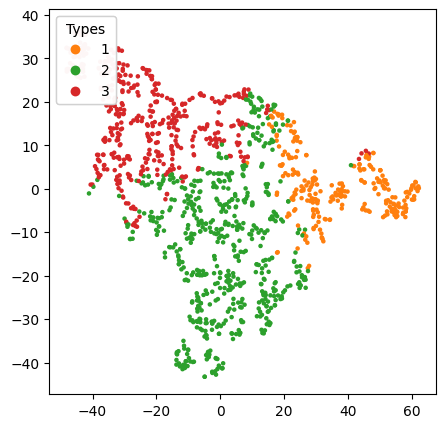

In [38]:
fig, ax = plt.subplots(figsize=(5,5))
scatter = ax.scatter(z[:, 0], z[:, 1], s=5, c=pred, vmin=0, vmax=9, cmap="tab10")
legend1 = ax.legend(*scatter.legend_elements(num=torch.unique(pred)),loc="upper left", title="Types")
ax.add_artist(legend1)
# plt.savefig('E:/Dataset/GNN_Perception/fig_out/kmeansplot.svg')
plt.show()

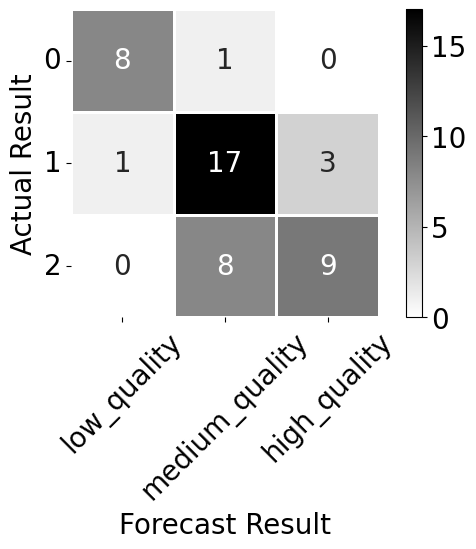

In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_labels, predictions)

## 绘制混淆矩阵
import seaborn as sns
import matplotlib.pyplot as plt
df_cm=pd.DataFrame(cm,
columns=["low_quality","medium_quality","high_quality"])#&Transport
# plt.figure(figsize=(10,8))
f, ax= plt.subplots(figsize = (7, 4))
 
h=sns.heatmap(df_cm,annot=True,cmap="binary",fmt='.20g',ax=ax,linewidths=2,
            annot_kws={'size':20},cbar=False,square=True)
 
#h=sns.heatmap(data, annot=True,fmt='d',linewidths=0.5,cbar=False) #设置不使用其默认自带的colorbar
cb=h.figure.colorbar(h.collections[0]) #显示colorbar
cb.ax.tick_params(labelsize=20) #设置colorbar刻度字体大小。
 
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
 
ax.tick_params(labelsize=20)
ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
 
plt.ylabel('Actual Result',fontsize=20)
plt.xlabel('Forecast Result',fontsize=20)
# plt.savefig('E:/Dataset/GNN_Perception/fig_out/confmatrix.svg',format='svg',bbox_inches='tight')
plt.show()

In [1]:
import torch
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

d:\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
edge_data = pd.read_csv('E:/Dataset/project_dataset/school_graph/edges.csv')

src = edge_data['src'].tolist()
dst = edge_data['dst'].tolist()

edge_index = torch.tensor([src, dst], dtype=torch.long)
# edge_attrs = torch.tensor(edge_data['weight'], dtype=torch.float)
edge_index,edge_index.shape

(tensor([[1107, 1107, 1107,  ...,   11,   11,   11],
         [1102, 1101, 1108,  ...,   18,    9,   19]]),
 torch.Size([2, 6345]))

In [3]:
df = pd.read_csv('E:/Dataset/project_dataset/school_graph/nodes.csv')

df_att = df.iloc[:,9:]
x = torch.tensor(df_att.to_numpy())[:, 1:].float()

x.shape

torch.Size([1288, 21])

In [6]:
# 构建数据集
df = pd.read_csv('E:/Dataset/project_dataset/school_graph/label.csv')

# 把空值替换成-1
df.fillna(-1, inplace=True)

# 平衡数据，把数量过多的标签删除
label_1 = df[df['label'] == 2]
num_rows_to_remove = int(len(label_1) * 0.3)
rows_to_change = np.random.choice(label_1.index, num_rows_to_remove, replace=False)
df.loc[rows_to_change, 'label'] = -1

# 平衡数据，把数量过多的标签删除
# label_1 = df[df['label'] == 3]
# num_rows_to_remove = int(len(label_1) * 0.1)
# rows_to_change = np.random.choice(label_1.index, num_rows_to_remove, replace=False)
# df.loc[rows_to_change, 'label'] = -1



# 上采样数据以平衡类别
ros = RandomOverSampler(random_state=0)
X = df.drop(['label'], axis=1)
y = torch.tensor(df['label'], dtype=torch.long)
X_resampled, y_resampled = ros.fit_resample(X, y)

# 将上采样后的数据转换为DataFrame格式
df_resampled = pd.DataFrame(
    data=np.column_stack((X_resampled, y_resampled)),
    columns=[*X.columns, 'label']
)

# 过滤掉label中为-1的行
filter_mask = np.where(df['label'] != -1, True, False)

# 划分训练集和测试集
train_node_ids, test_node_ids = train_test_split(
    df.index[filter_mask],
    test_size=0.2,
    stratify=df[filter_mask]['label'],
    random_state=12345
)

# 创建 'train_mask' 和 'test_mask' 特征属性，并将它们初始化为 False
train_mask = torch.zeros(len(x), dtype=torch.bool)
train_mask[train_node_ids] = True
test_mask = torch.zeros(len(x), dtype=torch.bool)
test_mask[test_node_ids] = True

#统计标签数量
from collections import Counter
Counter(df['label']), train_mask.sum().item(), test_mask.sum().item(), y.shape, train_mask.shape, test_mask.shape

(Counter({-1.0: 1081, 1.0: 32, 2.0: 91, 3.0: 84}),
 165,
 42,
 torch.Size([1288]),
 torch.Size([1288]),
 torch.Size([1288]))

In [7]:
data = Data(x=x, edge_index=edge_index,
# edge_attrs = edge_attrs,
y=y,
train_mask=train_mask,
test_mask=test_mask)
data

Data(x=[1288, 21], edge_index=[2, 6345], y=[1288], train_mask=[1288], test_mask=[1288])

In [36]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(21, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, 4)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=32)
print(model)

GCN(
  (conv1): GCNConv(21, 32)
  (conv2): GCNConv(32, 4)
)


In [38]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(21, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, 4)

    def forward(self, x, edge_index):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)       
        return x

model = GCN(hidden_channels=32)
print(model)

GCN(
  (conv1): GCNConv(21, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 4)
)


In [50]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.nn import global_mean_pool, global_max_pool


class GraphSAGE(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GraphSAGE, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = SAGEConv(21, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, 4)

    def forward(self, x, edge_index):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        
        return x

model = GraphSAGE(hidden_channels=64)
print(model)

GraphSAGE(
  (conv1): SAGEConv(21, 64, aggr=mean)
  (conv2): SAGEConv(64, 64, aggr=mean)
  (conv3): SAGEConv(64, 4, aggr=mean)
)


In [44]:
from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GATConv
from torch_geometric.nn import global_mean_pool, global_max_pool, global_add_pool


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GAT, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GATConv(21, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, 4)
        # self.lin = Linear(hidden_channels, 4)

    def forward(self, x, edge_index):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)       
        return x

model = GAT(hidden_channels=64)
print(model)

GAT(
  (conv1): GATConv(21, 64, heads=1)
  (conv2): GATConv(64, 64, heads=1)
  (conv3): GATConv(64, 4, heads=1)
)


In [51]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      out = model(data.x, data.edge_index)
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      optimizer.zero_grad()  # Clear gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      test_f1 = f1_score(data.y[data.test_mask].cpu().numpy(), pred[data.test_mask].cpu().numpy(), average='macro')
      return test_acc, test_f1

for epoch in range(1, 501):
      loss = train()
      test_acc, test_f1 = test()
      print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}', f'Test Accuracy: {test_acc:.4f}, Test F1 Score: {test_f1:.4f}')

Epoch: 001, Loss: 2.6927 Test Accuracy: 0.4286, Test F1 Score: 0.2000
Epoch: 002, Loss: 7.0852 Test Accuracy: 0.4286, Test F1 Score: 0.2000
Epoch: 003, Loss: 2.7665 Test Accuracy: 0.4048, Test F1 Score: 0.1921
Epoch: 004, Loss: 4.2734 Test Accuracy: 0.4048, Test F1 Score: 0.1921
Epoch: 005, Loss: 2.8674 Test Accuracy: 0.4286, Test F1 Score: 0.2787
Epoch: 006, Loss: 1.4759 Test Accuracy: 0.2381, Test F1 Score: 0.2047
Epoch: 007, Loss: 1.2359 Test Accuracy: 0.2857, Test F1 Score: 0.2631
Epoch: 008, Loss: 1.1711 Test Accuracy: 0.4286, Test F1 Score: 0.3051
Epoch: 009, Loss: 1.1082 Test Accuracy: 0.4524, Test F1 Score: 0.2867
Epoch: 010, Loss: 1.1083 Test Accuracy: 0.4286, Test F1 Score: 0.2000
Epoch: 011, Loss: 1.0951 Test Accuracy: 0.4286, Test F1 Score: 0.2000
Epoch: 012, Loss: 1.0980 Test Accuracy: 0.4286, Test F1 Score: 0.2000
Epoch: 013, Loss: 1.0805 Test Accuracy: 0.4048, Test F1 Score: 0.1921
Epoch: 014, Loss: 1.0802 Test Accuracy: 0.4286, Test F1 Score: 0.2787
Epoch: 015, Loss: 1.

In [23]:
from torch_geometric.explain import Explainer, GNNExplainer

explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',  # Model returns log probabilities.
    ),
)

In [24]:
# Generate explanation for the node:
explanation = explainer(data.x, data.edge_index, index=501)
print(explanation.edge_mask)
print(explanation.node_mask)

tensor([0., 0., 0.,  ..., 0., 0., 0.])
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


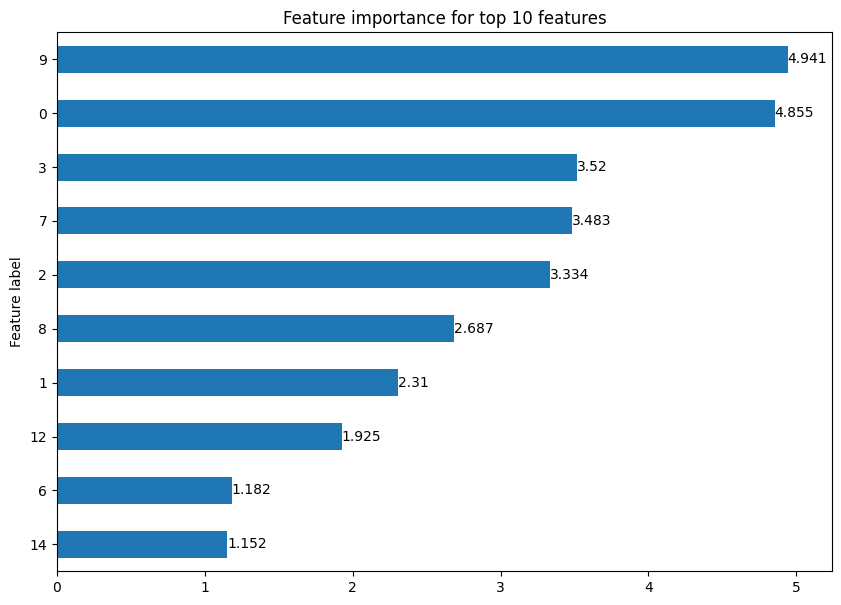

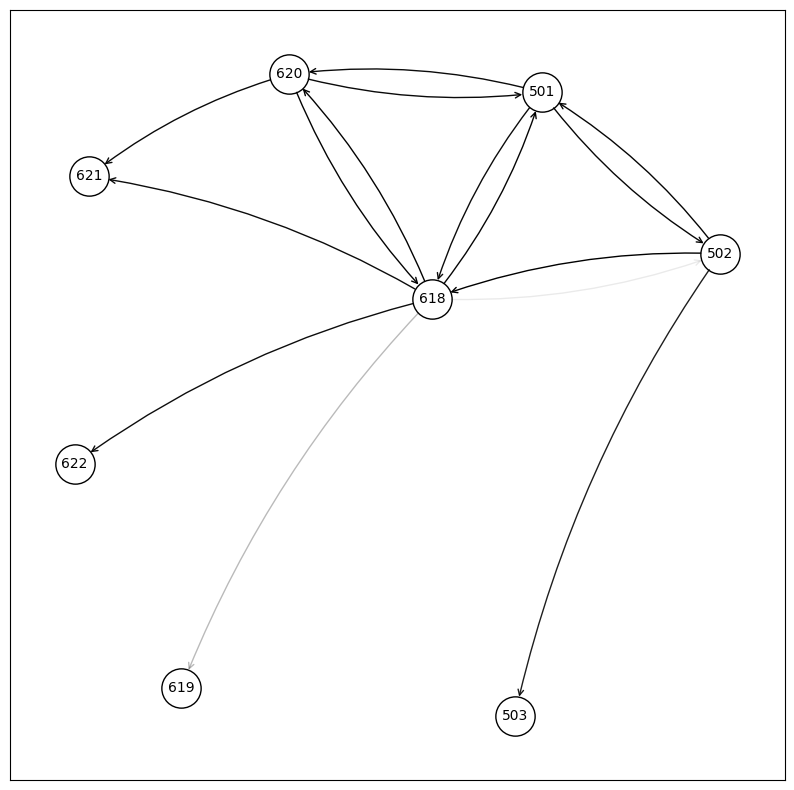

In [25]:
explanation.visualize_feature_importance(top_k=10)

fig= plt.subplots(figsize=(10,10))
explanation.visualize_graph()